Notebook for plotting ripple features during natural sleep.

#### NRK TODO: update for eeg file with multiple electrodes

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    plot_dir = Path("/Users/nkinsky/University of Michigan Dropbox/Nathaniel Kinsky/Shared_Folders/KD/Grants/R01_Anesthesia_as_SD/plots")
    # assert False, 'plot_dir not yet implemented on Nat laptop'
elif platform.system() == "Linux":
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        plot_dir = Path('/home/nkinsky/Dropbox (University of Michigan)/Shared_Folders/KD/Grants/R01_Anesthesia_as_SD/plots')
    if environ["HOSTNAME"] == "lnx00035":
        sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy/'])
        plot_dir = Path('/home/nkinsky/Dropbox (University of Michigan)/Shared_Folders/KD/Grants/R01_Anesthesia_as_SD/plots')
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from copy import deepcopy

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D
from neuropy.analyses.oscillations import detect_theta_epochs
from neuropy.core.position import Position
from neuropy.core.epoch import Epoch
from neuropy.core.neurons import Neurons
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten
from neuropy.io import BinarysignalIO

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/xarray/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
if platform.system() == "Darwin": # Nat laptop
    dir_use = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/Clustering/sessions/RatU/RatUDay2NSD")
    nchan_eeg = 1
    chan_use_rip = np.array([0])
    eeg_glob_str = "*thetachan.eeg"
elif platform.system() == "Linux":
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        # dir_use = None
        # assert False,  "No data on Nat linux computer"
        dir_use = Path("/data/Clustering/sessions/RatU/RatUDay2NSD/")
        nchan_eeg = 6
        chan_use_rip = np.arange(6)
        eeg_glob_str = "*08-16-38.swr_shank.eeg"
    if environ["HOSTNAME"] == "lnx00035":
        dir_use = Path("/data/Clustering/sessions/RatU/RatUDay2NSD/")
        nchan_eeg = 192
        chan_use_rip = np.arange(112, 127, 3)
        eeg_glob_str = "*08-16-38.eeg"

In [3]:
from neuropy.core.session import ProcessData

eegfile = BinarysignalIO(sorted(dir_use.glob(eeg_glob_str))[0], n_channels=nchan_eeg, sampling_rate=1250)
signal = eegfile.get_signal()

neurons = Neurons.load(sorted(dir_use.glob("*.neurons.stable.npy"))[0]).get_neuron_type("pyr")

ripple_epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.ripple.npy"))[0])
ripple_epochs

rec_epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.paradigm.npy"))[0])
rec_epochs

4 epochs
Snippet: 
    start   stop    label
0      0   9544      pre
1   9545  12855     maze
2  12856  45316     post
3  45317  48496  re-maze

In [11]:
from neuropy.analyses.oscillations import Ripple
id = 103
buffer = 0.25
rip_use = ripple_epochs.time_slice(rec_epochs["post"].starts[0], rec_epochs["post"].stops[-1])

mean_swr_wvlt = Ripple.get_mean_wavelet(eegfile, chan_use_rip[0], rip_use)

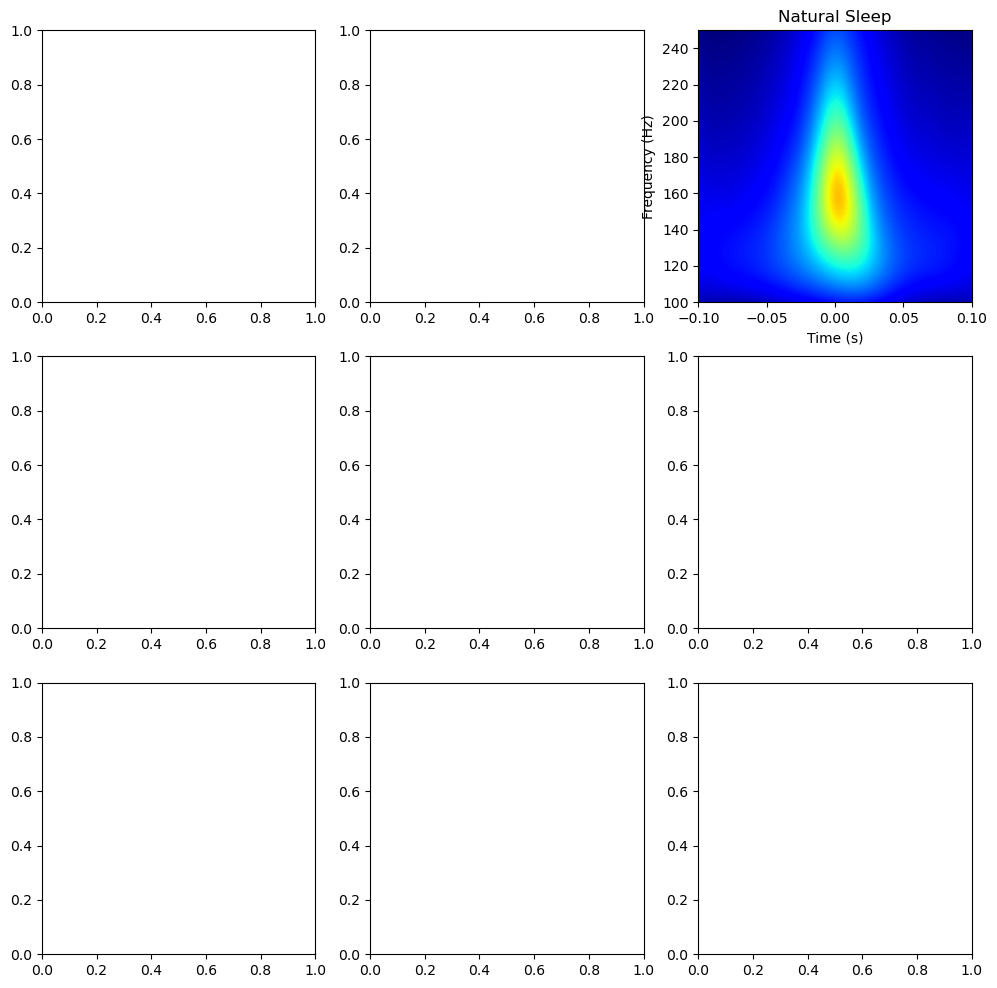

In [12]:
from neuropy.plotting.signals import plot_spectrogram
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
plot_spectrogram(mean_swr_wvlt.traces, time_lims=(-0.1, 0.1), freq_lims=(100, 250), widget=False, ax=ax[0][2])
ax[0][2].set_title("Natural Sleep")
# _, ax = plt.subplots()
# # sns.heatmap(mean_swr_wvlt.traces, cmap="jet", widget=False, freqax=ax)
fig.savefig(plot_dir / "NSD_wavelet_mean.pdf")

interactive(children=(IntSlider(value=106, description='SWR #', max=1000), Output()), _dom_classes=('widget-in…

<function __main__.plot_swr_w_pbe(id, axeeg, axspike)>

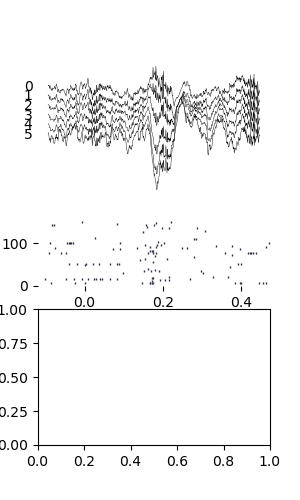

In [50]:
%matplotlib widget
import ipywidgets as widgets
buffer = 0.25
def plot_swr_w_pbe(id, axeeg, axspike):
    axeeg.clear()
    axspike.clear()
    plot_signal_traces(signal.time_slice(t_start=rip_use.starts[id] - buffer, t_stop=rip_use.stops[id] + buffer,
                                     channel_id=chan_use_rip), ax=axeeg, lw=0.3)
    plot_raster(neurons.time_slice(t_start=rip_use.starts[id] - buffer, t_stop=rip_use.stops[id] + buffer), ax=axspike)
    # plot_signal_traces(signal.time_slice(t_start=rip_use.to_dataframe().peak_time[id] - buffer, 
    #                                      t_stop=rip_use.to_dataframe().peak_time[id] + buffer,
    #                                      channel_id=chan_use_rip), 
    #                    ax=axeeg, lw=0.3)
    # plot_raster(neurons.time_slice(t_start=rip_use.to_dataframe().peak_time[id] - buffer, 
    #                                t_stop=rip_use.to_dataframe().peak_time[id] + buffer), 
                # ax=axspike)


fig, ax = plt.subplots(3, 1, figsize=(3, 5), height_ratios=[4, 2, 4])
for a in ax[0:2]:
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlabel("")
    a.set_ylabel("")
    sns.despine(ax=a, left=True, bottom=True)


widgets.interact(plot_swr_w_pbe,
                 id=widgets.IntSlider(min=0, max=1000, value=106, step=1, description="SWR #"),
                 axeeg=widgets.fixed(ax[0]),
                 axspike=widgets.fixed(ax[1]))

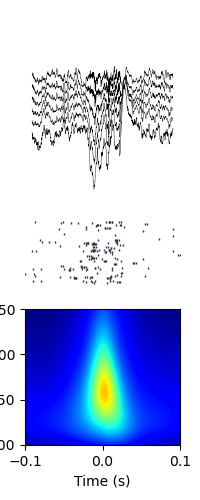

In [75]:
from neuropy.plotting.signals import plot_signal_traces
from neuropy.plotting.spikes import plot_raster

fig, ax = plt.subplots(3, 1, figsize=(2, 5), height_ratios=[4, 2, 4])

id = 377  # 106 is good but has out-of-ripple firing
buffer = 0.35
rip_use = ripple_epochs.time_slice(rec_epochs["post"].starts[0], rec_epochs["post"].stops[-1])
plot_signal_traces(signal.time_slice(t_start=rip_use.starts[id] - buffer, t_stop=rip_use.stops[id] + buffer,
                                     channel_id=chan_use_rip), ax=ax[0], lw=0.3)

plot_raster(neurons.time_slice(t_start=rip_use.starts[id] - buffer, t_stop=rip_use.stops[id] + buffer), ax=ax[1])

plot_spectrogram(mean_swr_wvlt.traces, time_lims=(-0.1, 0.1), freq_lims=(100, 250), widget=False, ax=ax[2])

for a in ax[0:2]:
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlabel("")
    a.set_ylabel("")
    sns.despine(ax=a, left=True, bottom=True)

fig.savefig(plot_dir / "NSD_SWR_w_PBE.pdf")

### Plot PBEs

In [6]:
from neuropy.core.neurons import binned_pe_raster
smooth_mua=True
buffer_sec = (0.2, 0.2)
if not smooth_mua:
    mua = neurons.get_mua(bin_size=0.01)
elif smooth_mua:
    mua = neurons.get_mua(bin_size=0.001).get_smoothed(sigma=0.02)
ripple_epochs_use = ripple_epochs.time_slice(rec_epochs["post"].starts[0], rec_epochs["post"].starts[0] + 600)
# fr_array = binned_pe_raster(mua, ripple_epochs_use.to_dataframe()["peak_time"].values, buffer_sec=buffer_sec, neuron_id=0)

In [53]:
buffer_frames = (np.array(buffer_sec) * eegfile.sampling_rate).astype(int)
buffer_frames2 = (np.array(buffer_sec) / mua.bin_size).astype(int)

In [52]:
rpl_peak_frames = (ripple_epochs_use.to_dataframe().peak_time.values * eegfile.sampling_rate).astype(int)
rpl_peak_frames2 = (ripple_epochs_use.to_dataframe().peak_time.values / mua.bin_size).astype(int)

In [33]:
mua.firing_rate.shape[0] * mua.bin_size

48498.534

In [40]:
peak_times = ripple_epochs_use.to_dataframe().peak_time.values

In [59]:
buffer_frames2[0]

200

In [69]:
mua.t_stop

48498.534

In [76]:
ripple_epochs_use = ripple_epochs.time_slice(rec_epochs["post"].starts[0], rec_epochs["post"].stops[-1])
rpl_peak_frames2 = (ripple_epochs_use.to_dataframe().peak_time.values / mua.bin_size).astype(int)
temp = 0
temp2 = []
mua_fr = mua.firing_rate
for peak_frame in rpl_peak_frames2:
    # start_stop = np.digitize([peak_time - buffer_sec[0], peak_time + buffer_sec[1]], mua.time)
    # inds.append(np.arange(start_stop[0], start_stop[1] + 1))
    # temp += mua.firing_rate[(peak_frame - buffer_frames2[0]):(peak_frame + buffer_frames2[1] + 1)]
    temp += mua_fr[(peak_frame - buffer_frames2[0]):(peak_frame + buffer_frames2[1] + 1)]
    temp2.append(mua_fr[(peak_frame - buffer_frames2[0]):(peak_frame + buffer_frames2[1] + 1)])

    

In [72]:
rpl_peak_frames2.shape

(13077,)

In [49]:
peak_time / mua.bin_size

13454514.4

In [43]:
peak_times[0] - buffer_sec[0]

12856.0384

In [64]:
mua.firing_rate.mean()

130.7977267931436

In [79]:
np.array(temp2).std(axis=0) / 

array([100.65426439, 100.7202347 , 100.79445528, 100.87694683,
       100.96760619, 101.0663057 , 101.17306744, 101.28769516,
       101.41020158, 101.54049992, 101.67858724, 101.82436975,
       101.97779275, 102.13872793, 102.30718899, 102.48295802,
       102.66604785, 102.85625254, 103.05350551, 103.25755053,
       103.46818185, 103.68513647, 103.90817929, 104.13699946,
       104.37129819, 104.61054364, 104.85431852, 105.10224282,
       105.35377665, 105.60839819, 105.86557394, 106.12461343,
       106.38503487, 106.64616198, 106.90737568, 107.16805377,
       107.42755363, 107.68526725, 107.94063674, 108.19292832,
       108.4417474 , 108.68634039, 108.92638062, 109.16127945,
       109.39048045, 109.61353957, 109.83006788, 110.03967129,
       110.24187273, 110.43633584, 110.62267365, 110.8004884 ,
       110.96938406, 111.12895072, 111.27880301, 111.41863328,
       111.54803106, 111.66644763, 111.77352705, 111.86891036,
       111.95194635, 112.02234089, 112.07951537, 112.12

### Plan: try normalizing to overall firing rates of MUA, could be very small mean and std for sedation though, which could give very large z scores!  If so, normalize using mean and std from MAZE, not from sedation periods.

In [88]:
mua_mean = mua.firing_rate.mean()
mua_std = mua.firing_rate.std()

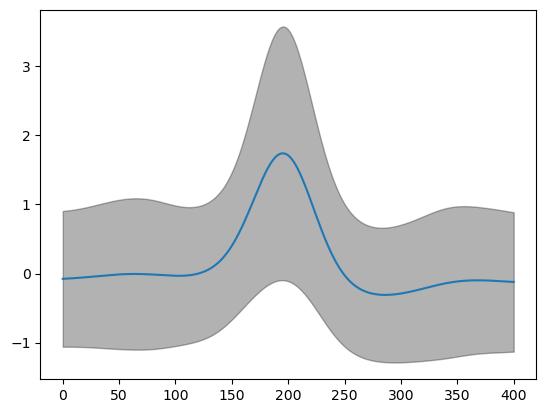

In [90]:
_, ax = plt.subplots()
fr_array = np.array(temp2)
fr_z = (fr_array.mean(axis=0) - mua_mean) / mua_std
ax.plot(fr_z )
ax.fill_between(np.arange(fr_z.shape[0]), 
                fr_z - fr_array.std(axis=0) / mua_std, 
                fr_z + fr_array.std(axis=0) / mua_std, 
                color=[0, 0, 0, 0.3])

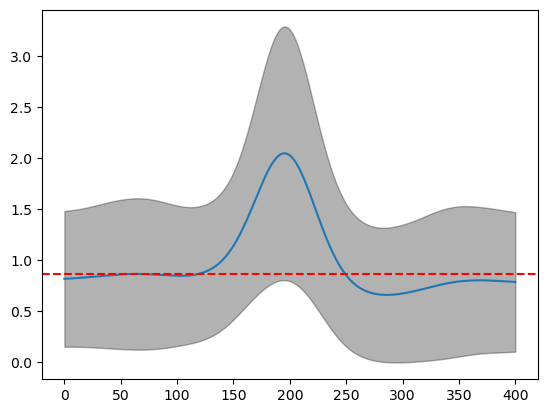

In [86]:
_, ax = plt.subplots()
ax.plot(np.array(temp2).mean(axis=0) / neurons.n_neurons)
ax.fill_between(np.arange(temp2[0].shape[0]), 
                (np.array(temp2).mean(axis=0) - np.array(temp2).std(axis=0)) / neurons.n_neurons,
                (np.array(temp2).mean(axis=0) + np.array(temp2).std(axis=0)) / neurons.n_neurons,
                color=[0, 0, 0, 0.3])
ax.axhline(mua.firing_rate.mean() / neurons.n_neurons, color='r', linestyle='--')

In [16]:
fr_array_test = 0
for rpl_peak in rpl_peak_frames:
    # fr_array_test.append(mua.firing_rate[(rpl_peak - buffer_frames[0]):(rpl_peak + buffer_frames[1] + 1)])
    fr_array_test += mua.firing_rate[(rpl_peak - buffer_frames[0]):(rpl_peak + buffer_frames[1] + 1)]
fr_array_test


array([64094.99705476, 64196.07358867, 64297.99857727, 64400.49382423,
       64503.09020997, 64605.77457345, 64708.30370974, 64810.1452508 ,
       64911.20530311, 65011.09526527, 65109.69108097, 65206.67813001,
       65301.75742823, 65394.7393048 , 65485.50752542, 65573.91338839,
       65659.4133704 , 65741.98660933, 65821.47858718, 65897.73920641,
       65970.56043661, 66039.74705563, 66104.96900618, 66166.36390082,
       66223.66480251, 66276.55929883, 66325.06888413, 66368.96446294,
       66408.30690337, 66442.96799035, 66472.69442639, 66497.52576723,
       66517.37686382, 66532.19583163, 66541.98081805, 66546.76981903,
       66546.60068218, 66541.55312987, 66531.79065092, 66517.02746092,
       66497.9036276 , 66474.41198377, 66446.66121379, 66414.88054735,
       66379.42523607, 66340.65569551, 66298.69996246, 66254.00397796,
       66206.90301176, 66157.73770864, 66107.00769861, 66054.87565264,
       66002.12480847, 65948.75001299, 65895.46723103, 65842.65527481,
      

In [46]:
fr_array[0].mean(axis=0)

array([188.6178714 , 188.43778986, 188.29655451, 188.19412371,
       188.13203728, 188.11008219, 188.12899912, 188.18960289,
       188.29194478, 188.43637308, 188.62310006, 188.85205577,
       189.12396041, 189.43916362, 189.7970027 , 190.19773934,
       190.64171111, 191.12768148, 191.65638799, 192.22704885,
       192.83927218, 193.49244195, 194.18670172, 194.92031283,
       195.69244695, 196.50253795, 197.34991757, 198.23291706,
       199.15001671, 200.09991703, 201.08143756, 202.0924463 ,
       203.13172286, 204.19694153, 205.28641492, 206.39761492,
       207.52839219, 208.67613368, 209.83904022, 211.01381964,
       212.19782667, 213.38874765, 214.58323324, 215.77887854,
       216.97230902, 218.16048232, 219.34050145, 220.50874172,
       221.66275671, 222.79884279, 223.91427102, 225.00576369,
       226.0697878 , 227.10358821, 228.10454773, 229.06915483,
       229.99467196, 230.87838774, 231.71790154, 232.5103666 ,
       233.25360771, 233.94537924, 234.5830468 , 235.16

In [44]:
ripple_epochs_use

575 epochs
Snippet: 
         start        stop   peak_time  peak_power  peak_frequency  \
0  12856.1568  12856.2848  12856.2384    3.986918      250.000000   
1  12858.3008  12858.4152  12858.3712    2.829021      250.000000   
2  12858.7800  12858.9280  12858.8648    3.429032      250.000000   
3  12858.9384  12859.0408  12858.9832    2.623543      125.757576   
4  12859.3776  12859.7392  12859.6872    5.072625      174.242424   

   peak_frequency_bp  sharp_wave_amp label  
0         145.454545        2.967872        
1         236.363636        4.265444        
2         184.848485        5.134078        
3         125.757576        2.886133        
4         171.212121        4.728995        

In [43]:
rpl_peak

16818143

In [35]:
np.mean(fr_array, axis=0)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [19]:
ripple_epochs.n_epochs

24742

In [17]:
ripple_epochs_use

575 epochs
Snippet: 
         start        stop   peak_time  peak_power  peak_frequency  \
0  12856.1568  12856.2848  12856.2384    3.986918      250.000000   
1  12858.3008  12858.4152  12858.3712    2.829021      250.000000   
2  12858.7800  12858.9280  12858.8648    3.429032      250.000000   
3  12858.9384  12859.0408  12858.9832    2.623543      125.757576   
4  12859.3776  12859.7392  12859.6872    5.072625      174.242424   

   peak_frequency_bp  sharp_wave_amp label  
0         145.454545        2.967872        
1         236.363636        4.265444        
2         184.848485        5.134078        
3         125.757576        2.886133        
4         171.212121        4.728995        

In [18]:
fr_array[0].shape

(575, 401)

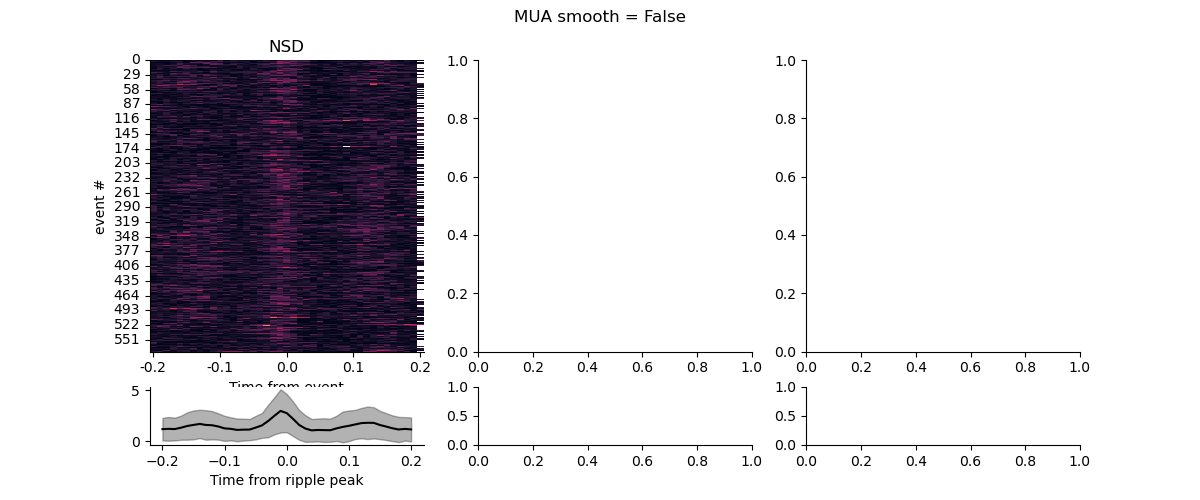

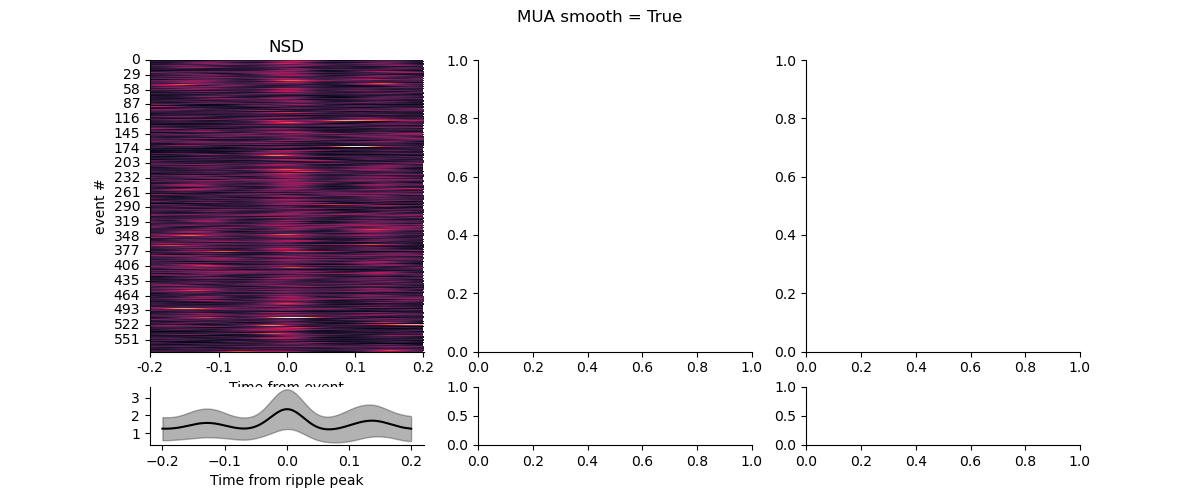

In [73]:
%matplotlib widget
norm_by_n_neurons = True
buffer_sec = (0.2, 0.2)
from neuropy.plotting.spikes import plot_mua, plot_raster, plot_binned_raster

for smooth_mua in [False, True]:
    fig, axall = plt.subplots(2, 3, height_ratios=[5, 1], figsize=(12, 5), sharex=False)
    fig.suptitle(f"MUA smooth = {smooth_mua}")
    axs = axall[:, 0]

    if not smooth_mua:
        mua = neurons.get_mua(bin_size=0.01)
    elif smooth_mua:
        mua = neurons.get_mua(bin_size=0.001).get_smoothed(sigma=0.02)
    # plot_mua(sess.mua)

    # ripple_epochs_use = ripple_epochs.time_slice(rec_epochs["post"].starts[0], rec_epochs["post"].stops[-1])
    ripple_epochs_use = ripple_epochs.time_slice(rec_epochs["post"].starts[0], rec_epochs["post"].starts[0] + 600)
    
    ax, fr_array, pe_times = plot_binned_raster(mua, ripple_epochs_use.to_dataframe()["peak_time"].values, buffer_sec=buffer_sec, 
                                                ax=axs[0], cbar=None)
    
    axs[0].set_title("NSD")

    fr_mean, fr_std = np.nanmean(fr_array, axis=0), np.nanstd(fr_array, axis=0)
    fr_norm = neurons.n_neurons if norm_by_n_neurons else 1
    axs[1].plot(pe_times, fr_mean / fr_norm, 'k-')
    axs[1].fill_between(pe_times, (fr_mean - fr_std) / fr_norm, (fr_mean + fr_std) / fr_norm, color=[0, 0, 0, 0.3])
    axs[1].set_xlabel("Time from ripple peak")

    sns.despine(fig=fig)